# 风电功率预测：使用CatBoost进行16点预测

本notebook使用CatBoost来预测风电功率未来16个时间点的值（对应4小时，每15分钟一个点）。
由于CatBoost每次只能预测一个目标值，我们将训练16个独立的模型，每个模型预测未来的一个特定时间点。

## 任务说明
- 输入: 过去96个时间点的风电功率数据（对应24小时，每15分钟一个点）
- 输出: 未来16个时间点的风电功率预测（对应4小时）
- 方法: 训练16个CatBoost模型，每个模型预测未来的一个特定时间点

只用了三个特征 Feature names: ['i-1_power', 'min_power', 'max_power']

In [1]:
# ===== 超参数配置 =====
# 集中管理所有超参数，方便调试和调优

class Config:
    # 数据相关
    seq_length = 8         # 输入序列长度（96个时间点，24小时，每点15分钟）
    pred_length = 16         # 预测序列长度（16个时间点，4小时）
    train_val_split = 0.8    # 训练验证集分割比例
    
    # 数据加载
    batch_size = 128         # 批大小（仅用于测试数据预处理）
    num_workers = 8          # 数据加载器工作进程数
    
    # 风电功率特征工程相关
    use_feature_engineering = False  # 是否使用特征工程
    time_interval_minutes = 15      # 时间间隔（分钟）

    add_lag_features = False        # 添加滞后特征（风电功率有自相关性）
    lag_steps = [1, 2, 4, 8, 16, 24, 48, 96]  # 滞后步数（15min, 30min, 1h, 2h, 4h, 6h, 12h, 24h）

    add_ramp_features = False       # 添加功率爬坡特征（风电重要特性）
    ramp_windows = [4, 8, 16]      # 爬坡检测窗口
    add_variability_features = False # 添加变异性特征
    add_persistence_features = False  # 添加持续性特征
    
    # CatBoost模型参数
    learning_rate = 0.05
    max_depth = 12
    n_estimators = 1000
    l2_leaf_reg = 3.0
    random_strength = 1.0
    bagging_temperature = 1.0
    od_type = 'Iter'
    od_wait = 50             # 早停轮数
    verbose = 100            # 训练过程打印间隔
    
    # 训练相关
    num_epochs = 1           # CatBoost不需要多个epoch
    early_stop_min_delta = 0.0001  # 早停最小改善幅度
    
    # 并行训练配置
    use_parallel_training = True  # 是否使用并行训练
    max_processes = 4      # 最大并行进程数（设置为模型数量）
    
    # 其他
    random_seed = 42         # 随机种子
    task_type = 'CPU'        # 'CPU' 或 'GPU'

    
    # 路径配置
    data_dir = '/data/jinming/ee_prediction/data'
    model_save_dir = '/data/jinming/ee_prediction/catboost/models'
    results_dir = '/data/jinming/ee_prediction/catboost/results'
    
# 创建配置实例
config = Config()

print("=== Hyperparameter Configuration ===")
print(f"Time Configuration: {config.seq_length} points ({config.seq_length * config.time_interval_minutes / 60:.1f}h) -> {config.pred_length} points ({config.pred_length * config.time_interval_minutes / 60:.1f}h)")
print(f"Feature Engineering: Enabled={config.use_feature_engineering}")
print(f"CatBoost Model: Max depth {config.max_depth}, Learning rate {config.learning_rate}, Estimators {config.n_estimators}")
print(f"Task type: {config.task_type}")
print(f"Parallel Training: {config.use_parallel_training} (Max processes: {config.max_processes})")
print("=" * 50)

=== Hyperparameter Configuration ===
Time Configuration: 8 points (2.0h) -> 16 points (4.0h)
Feature Engineering: Enabled=False
CatBoost Model: Max depth 12, Learning rate 0.05, Estimators 1000
Task type: CPU
Parallel Training: True (Max processes: 4)


In [2]:
# 导入所需库
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor, Pool
import json
import time
from tqdm import tqdm
import warnings
import multiprocessing as mp
from multiprocessing import Pool as ProcessPool
from functools import partial
import shap

warnings.filterwarnings('ignore')

# 设置随机种子确保可重现性
np.random.seed(config.random_seed)

# 确保目录存在
os.makedirs(config.model_save_dir, exist_ok=True)
os.makedirs(config.results_dir, exist_ok=True)

# 特征选择配置 - 允许为每个模型指定输入特征
class FeatureSelector:
    """特征选择器 - 允许为每个预测时间点选择不同的输入特征"""
    
    def __init__(self, total_time_points=96):
        self.total_time_points = total_time_points
        self.feature_configs = {}
        self.auto_select_enabled = False
        self.shap_based_selection = False
    
    def set_features_for_horizon(self, horizon, feature_indices):
        """为指定的预测时间点设置输入特征
        
        Args:
            horizon: 预测时间点 (1-16)
            feature_indices: 特征索引列表，例如 [1,2,3,4] 表示使用 t-1, t-2, t-3, t-4
        """
        self.feature_configs[horizon] = feature_indices
    
    def enable_auto_selection(self, method='importance', top_k=32):
        """启用自动特征选择
        
        Args:
            method: 选择方法 ('importance', 'shap', 'correlation')
            top_k: 选择前k个最重要的特征
        """
        self.auto_select_enabled = True
        self.selection_method = method
        self.top_k = top_k
        if method == 'shap':
            self.shap_based_selection = True
    
    def get_features_for_horizon(self, horizon):
        """获取指定预测时间点的特征索引"""
        if horizon in self.feature_configs:
            return self.feature_configs[horizon]
        else:
            # 默认使用所有96个时间点
            return list(range(1, self.total_time_points + 1))
    
    def get_feature_names_for_horizon(self, horizon):
        """获取指定预测时间点的特征名称"""
        indices = self.get_features_for_horizon(horizon)
        return [f't-{i}' for i in indices]
    
    def auto_select_features(self, model, X_data, horizon, method='importance'):
        """基于模型自动选择特征"""
        if not self.auto_select_enabled:
            return list(range(1, self.total_time_points + 1))
        
        if method == 'shap' and SHAP_AVAILABLE:
            # 使用SHAP进行特征选择
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_data[:min(500, len(X_data))])
            feature_importance = np.abs(shap_values).mean(0)
        else:
            # 使用CatBoost内置特征重要性
            feature_importance = model.get_feature_importance()
        
        # 选择前top_k个最重要的特征
        top_indices = np.argsort(feature_importance)[::-1][:self.top_k]
        selected_features = [i+1 for i in top_indices]  # 转换为t-x格式
        return sorted(selected_features)

# 创建特征选择器实例
feature_selector = FeatureSelector()

# 示例配置 - 可以为不同的预测时间点配置不同的特征集合
# 这里展示如何配置前几个模型使用不同的特征集合
# feature_selector.set_features_for_horizon(1, list(range(1, 17)))  # t+1 使用前16个时间点
# feature_selector.set_features_for_horizon(4, list(range(1, 33)))  # t+4 使用前32个时间点
# feature_selector.set_features_for_horizon(8, list(range(1, 49)))  # t+8 使用前48个时间点
# feature_selector.set_features_for_horizon(16, list(range(1, 97))) # t+16 使用所有96个时间点

# 启用自动特征选择（可选）
feature_selector.enable_auto_selection(method='shap', top_k=48)

print("Feature selection configuration ready.")
print("Use feature_selector.set_features_for_horizon(horizon, indices) to configure features for each model.")
print("Use feature_selector.enable_auto_selection() to enable automatic feature selection.")

print(f'Using task type: {config.task_type}')
print(f'Parallel training enabled: {config.use_parallel_training}')
if config.use_parallel_training:
    print(f'Maximum processes: {config.max_processes}')

Feature selection configuration ready.
Use feature_selector.set_features_for_horizon(horizon, indices) to configure features for each model.
Use feature_selector.enable_auto_selection() to enable automatic feature selection.
Using task type: CPU
Parallel training enabled: True
Maximum processes: 4


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# 加载数据
train_data = pd.read_excel(f'{config.data_dir}/train.xlsx')
test_data = pd.read_excel(f'{config.data_dir}/test.xlsx')

# 提取功率数据（第一列是实际功率）
train_power = train_data.iloc[:, 0].values
test_power = test_data.iloc[:, 0].values

print(f"Training data length: {len(train_power)}")
print(f"Testing data length: {len(test_power)}")
print(f"Training data range: [{train_power.min():.4f}, {train_power.max():.4f}]")
print(f"Testing data range: [{test_power.min():.4f}, {test_power.max():.4f}]")

# 检查原始数据中的负数情况
train_negative_count = np.sum(train_power < 0)
test_negative_count = np.sum(test_power < 0)
print(f"Original negative values in training data: {train_negative_count}")
print(f"Original negative values in testing data: {test_negative_count}")
if train_negative_count > 0 or test_negative_count > 0:
    print("Negative values will be converted to 0 during preprocessing")

# 数据预处理（简化版：数据已经归一化，只需处理负值）
def simplified_data_preprocessing(data, config):
    """简化的数据预处理：只处理负值转换为0"""
    processed_data = data.copy()
    
    # 将负数转换为0（这是唯一需要的预处理步骤）
    processed_data = np.where(processed_data < 0, 0, processed_data)
    
    print(f"Processed data range: [{processed_data.min():.4f}, {processed_data.max():.4f}]")
    negative_count = np.sum(data < 0)
    if negative_count > 0:
        print(f"Converted {negative_count} negative values to 0")
    else:
        print("No negative values found")
    
    return processed_data, None  # 返回None作为scaler（不需要）

# 应用简化预处理
if config.use_feature_engineering:
    print("\n=== Simplified Data Preprocessing ===")
    train_power_processed, train_scaler = simplified_data_preprocessing(train_power, config)
    test_power_processed, test_scaler = simplified_data_preprocessing(test_power, config)
    
    print(f"Final training data range: [{train_power_processed.min():.4f}, {train_power_processed.max():.4f}]")
    print(f"Final testing data range: [{test_power_processed.min():.4f}, {test_power_processed.max():.4f}]")
else:
    # 即使不使用特征工程，也需要简单的负值处理
    train_power_processed = np.where(train_power < 0, 0, train_power)
    test_power_processed = np.where(test_power < 0, 0, test_power)
    train_scaler = None
    test_scaler = None
    print("Applied basic negative value conversion only")

Training data length: 6999
Testing data length: 2999
Training data range: [-0.0094, 1.0000]
Testing data range: [-0.0093, 0.9446]
Original negative values in training data: 445
Original negative values in testing data: 138
Negative values will be converted to 0 during preprocessing
Applied basic negative value conversion only


In [4]:
# 特征工程函数
def create_features(data, seq_length, config):
    """
    为每个时间窗口创建特征
    
    参数:
    data: 原始时间序列数据
    seq_length: 输入序列长度
    config: 配置对象
    
    返回:
    features: 特征矩阵 [样本数, 特征数]
    feature_names: 特征名称列表
    """
    features_list = []
    feature_names = []
    
    power_series = pd.Series(data)
    
    # 1. 基本特征 - 最后一个时间点的功率值
    features_list.append(data[-1])
    feature_names.append('i-1_power')

    # features_list.append(data[-2])
    # feature_names.append('i-2_power')

    # 2. 统计特征 - 输入序列的统计量
    # features_list.append(np.mean(data))
    # feature_names.append('mean_power')
    
    # features_list.append(np.std(data))
    # feature_names.append('std_power')
    
    # features_list.append(np.min(data))
    # feature_names.append('min_power')
    
    # features_list.append(np.max(data))
    # feature_names.append('max_power')
    
    # 3. 滞后特征
    if config.add_lag_features:
        for lag in config.lag_steps:
            if lag < len(data):
                features_list.append(data[-lag])
                feature_names.append(f'lag_{lag}')
    
    # 4. 功率爬坡特征
    if config.add_ramp_features:
        for window in config.ramp_windows:
            # 功率爬坡率：单位时间内功率变化幅度
            if window < len(data):
                ramp_rate = data[-1] - data[-(window+1)]
                features_list.append(ramp_rate)
                feature_names.append(f'ramp_rate_{window}')
                
                # 绝对爬坡率
                abs_ramp_rate = np.abs(ramp_rate)
                features_list.append(abs_ramp_rate)
                feature_names.append(f'abs_ramp_rate_{window}')
                
                # 爬坡方向（上升=1，下降=-1，稳定=0）
                ramp_direction = np.sign(ramp_rate)
                features_list.append(ramp_direction)
                feature_names.append(f'ramp_direction_{window}')
    
    # 5. 功率变异性特征
    if config.add_variability_features:
        # 变异系数（标准差/均值）
        for window in [8, 16, 24, 48]:
            if window < len(data):
                window_data = data[-window:]
                window_mean = np.mean(window_data)
                window_std = np.std(window_data)
                cv = window_std / (window_mean + 1e-8)  # 避免除零
                features_list.append(cv)
                feature_names.append(f'coeff_var_{window}')
            
        # 功率分位数特征
        for window in [16, 48, 96]:
            if window < len(data):
                window_data = data[-window:]
                q25 = np.percentile(window_data, 25)
                q75 = np.percentile(window_data, 75)
                iqr = q75 - q25
                
                features_list.append(q25)
                feature_names.append(f'q25_{window}')
                
                features_list.append(q75)
                feature_names.append(f'q75_{window}')
                
                features_list.append(iqr)
                feature_names.append(f'iqr_{window}')
    
    # 6. 功率持续性特征
    if config.add_persistence_features:
        # 相对功率：当前功率相对于最近平均功率的比值
        for window in [4, 8, 16, 24]:
            if window < len(data):
                window_data = data[-window:]
                window_mean = np.mean(window_data)
                relative_power = data[-1] / (window_mean + 1e-8)  # 避免除零
                features_list.append(relative_power)
                feature_names.append(f'relative_power_{window}')
        
        # 功率趋势（局部线性回归斜率）
        for window in [8, 16, 24]:
            if window < len(data):
                x = np.arange(window)
                y = data[-window:]
                # 简单线性回归斜率
                slope = np.polyfit(x, y, 1)[0]
                features_list.append(slope)
                feature_names.append(f'trend_{window}')
        
        # 功率稳定性指标
        for window in [8, 16, 24]:
            if window < len(data):
                window_data = data[-window:]
                diffs = np.abs(np.diff(window_data))
                stability = np.mean(diffs)
                features_list.append(stability)
                feature_names.append(f'stability_{window}')
    
    return np.array(features_list), feature_names

# 准备CatBoost数据
# filepath: [catboost_16_point_prediction.ipynb](http://_vscodecontentref_/0)
def prepare_catboost_data(data, seq_length, pred_length, config, is_test=False):
    """
    准备CatBoost数据
    
    参数:
    data: 原始时间序列数据
    seq_length: 输入序列长度
    pred_length: 预测序列长度
    config: 配置对象
    is_test: 是否为测试集
    
    返回:
    X: 特征矩阵 [样本数, 特征数]
    y: 目标矩阵 [样本数, pred_length]（如果is_test=True则为None）
    feature_names: 特征名称列表
    """
    X_list = []
    y_list = []
    
    # 对于训练和测试数据，都需要确保有足够的数据点来构造完整的预测目标
    if is_test:
        # 测试数据也需要确保有完整的预测目标用于评估
        max_idx = len(data) - pred_length + 1
    else:
        # 训练数据
        max_idx = len(data) - pred_length + 1
    
    # 对每个样本进行特征工程
    for i in range(seq_length, max_idx):
        # 获取当前样本的输入序列
        input_seq = data[i - seq_length:i]
        
        # 对输入序列进行特征工程
        features, feature_names = create_features(input_seq, seq_length, config)
        X_list.append(features)
        
        # 添加目标值（训练和测试都需要，用于评估）
        if i + pred_length <= len(data):
            y_list.append(data[i:i + pred_length])
        else:
            # 如果数据不足pred_length，则填充NaN或跳过
            break
    
    X = np.array(X_list)
    y = np.array(y_list) if y_list else None
    
    return X, y, feature_names

# 生成训练和测试数据
print("Preparing training data...")
X_train, y_train, feature_names = prepare_catboost_data(train_power_processed, config.seq_length, config.pred_length, config)

print("Preparing test data...")
X_test, y_test, _ = prepare_catboost_data(test_power_processed, config.seq_length, config.pred_length, config)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape if y_test is not None else 'None'}")
print(f"Number of features: {len(feature_names)}")
print(f"Feature names: {feature_names}")

# 按训练集和验证集分割数据（时间顺序）
train_size = int(len(X_train) * config.train_val_split)
X_train_split = X_train[:train_size]
y_train_split = y_train[:train_size]
X_val = X_train[train_size:]
y_val = y_train[train_size:]

print(f"Training set size: {len(X_train_split)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

Preparing training data...
Preparing test data...
X_train shape: (6976, 1)
y_train shape: (6976, 16)
X_test shape: (2976, 1)
y_test shape: (2976, 16)
Number of features: 1
Feature names: ['i-1_power']
Training set size: 5580
Validation set size: 1396
Testing set size: 2976


In [5]:
# 训练16个CatBoost模型，每个模型预测一个未来时间点
models = []
training_metrics = []

# 评估指标计算函数
def calculate_CR(PM, PP):
    """
    计算CR指标（准确度指标）
    
    参数:
    PM: 实际值数组
    PP: 预测值数组
    
    返回:
    CR: CR指标值（百分比）
    """
    N = len(PM)
    Ri = np.zeros(N)
    for i in range(N):
        if PM[i] > 0.2:
            Ri[i] = (PM[i] - PP[i]) / PM[i]
        else:
            Ri[i] = (PM[i] - PP[i]) / 0.2
    rms_error = np.sqrt(np.mean(Ri**2))
    CR = (1 - rms_error) * 100
    return CR

def calculate_metrics(y_true, y_pred):
    """计算各种评估指标"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # 使用正确的CR计算方法
    cr = calculate_CR(y_true, y_pred)
    
    return {
        'rmse': rmse,
        'mae': mae,
        'cr': cr
    }

# 并行训练函数
def train_single_model(model_idx, X_train_split, y_train_split, X_val, y_val, config):
    """
    训练单个CatBoost模型的函数，用于并行处理
    
    参数:
    model_idx: 模型索引（0-15）
    X_train_split: 训练特征
    y_train_split: 训练目标
    X_val: 验证特征
    y_val: 验证目标
    config: 配置对象
    
    返回:
    model: 训练好的模型
    metrics: 训练指标
    model_idx: 模型索引
    """
    # 为当前时间点创建CatBoost模型
    model = CatBoostRegressor(
        iterations=config.n_estimators,
        learning_rate=config.learning_rate,
        depth=config.max_depth,
        l2_leaf_reg=config.l2_leaf_reg,
        random_strength=config.random_strength,
        bagging_temperature=config.bagging_temperature,
        od_type=config.od_type,
        od_wait=config.od_wait,
        verbose=False,  # 关闭详细输出以避免并行时的混乱
        random_seed=config.random_seed + model_idx ,  # 为每个模型设置不同的随机种子
        task_type=config.task_type
    )
    
    # 训练模型
    model.fit(
        X_train_split, y_train_split[:, model_idx],
        eval_set=[(X_val, y_val[:, model_idx])],
        use_best_model=True,
        early_stopping_rounds=config.od_wait,
        verbose=False  # 关闭详细输出
    )
    
    # 在验证集上评估
    val_pred = model.predict(X_val)
    val_metrics = calculate_metrics(y_val[:, model_idx], val_pred)
    
    # 保存模型
    model_path = f"{config.model_save_dir}/catboost_point_{model_idx+1}.cbm"
    model.save_model(model_path)
    
    # 返回结果
    metrics = {
        'horizon': model_idx+1,
        'best_iteration': model.best_iteration_,
        'train_rmse': model.get_best_score()['learn']['RMSE'],
        'val_rmse': model.get_best_score()['validation']['RMSE'],
        'val_custom_metrics': val_metrics
    }
    
    return model, metrics, model_idx

print("Training 16 CatBoost models...")

if config.use_parallel_training:
    print(f"Using parallel training with {config.max_processes} processes")
    
    # 创建进程池
    with ProcessPool(processes=config.max_processes) as pool:
        # 准备并行训练任务
        train_tasks = []
        for i in range(config.pred_length):
            # 使用 partial 函数来固定参数
            task = partial(
                train_single_model,
                i, X_train_split, y_train_split, X_val, y_val, config
            )
            train_tasks.append(task)
        
        # 执行并行训练
        print("Starting parallel training...")
        results = []
        for i, task in enumerate(train_tasks):
            print(f"Submitting model {i+1} for training...")
            result = pool.apply_async(task)
            results.append(result)
        
        # 收集结果
        trained_models = [None] * config.pred_length
        all_metrics = [None] * config.pred_length
        
        print("Waiting for training completion...")
        for i, result in enumerate(results):
            try:
                model, metrics, model_idx = result.get(timeout=3600)  # 1小时超时
                trained_models[model_idx] = model
                all_metrics[model_idx] = metrics
                print(f"Model {model_idx+1} completed: Val RMSE = {metrics['val_custom_metrics']['rmse']:.6f}, Val CR = {metrics['val_custom_metrics']['cr']:.2f}%")
            except Exception as e:
                print(f"Error training model {i+1}: {e}")
                raise
        
        # 将结果赋值给全局变量
        models = trained_models
        training_metrics = all_metrics
        
else:
    # 顺序训练（作为备选方案）
    print("Using sequential training")
    for i in tqdm(range(config.pred_length), desc="Training models"):
        model, metrics, _ = train_single_model(i, X_train_split, y_train_split, X_val, y_val, config)
        models.append(model)
        training_metrics.append(metrics)
        print(f"Model {i+1}: Val RMSE = {metrics['val_custom_metrics']['rmse']:.6f}, Val CR = {metrics['val_custom_metrics']['cr']:.2f}%")

# 保存训练指标
with open(f"{config.results_dir}/training_metrics.json", "w") as f:
    json.dump(training_metrics, f, indent=2)

print("All models trained and saved successfully.")
print(f"Training completed using {'parallel' if config.use_parallel_training else 'sequential'} processing.")

Training 16 CatBoost models...
Using parallel training with 4 processes
Starting parallel training...
Submitting model 1 for training...
Submitting model 2 for training...
Submitting model 3 for training...
Submitting model 4 for training...
Submitting model 5 for training...
Submitting model 6 for training...
Submitting model 7 for training...
Submitting model 8 for training...
Submitting model 9 for training...
Submitting model 10 for training...
Submitting model 11 for training...
Submitting model 12 for training...
Submitting model 13 for training...
Submitting model 14 for training...
Submitting model 15 for training...
Submitting model 16 for training...
Waiting for training completion...
Model 1 completed: Val RMSE = 0.043148, Val CR = 83.78%
Model 2 completed: Val RMSE = 0.065352, Val CR = 76.09%
Model 3 completed: Val RMSE = 0.077560, Val CR = 71.78%
Model 4 completed: Val RMSE = 0.085257, Val CR = 69.08%
Model 5 completed: Val RMSE = 0.090688, Val CR = 66.94%
Model 6 complete

In [6]:
# 在测试集上评估模型
print("Evaluating models on test set...")

# 准备收集测试结果
test_predictions = np.zeros((len(X_test), config.pred_length))
test_metrics_overall = {}
test_metrics_by_point = []

# 使用每个模型进行预测
for i in range(config.pred_length):
    model = models[i]
    test_predictions[:, i] = model.predict(X_test)

# 计算整体性能指标
rmse_overall = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
mae_overall = mean_absolute_error(y_test.flatten(), test_predictions.flatten())

# 使用统一的CR计算方法
cr_overall = calculate_CR(y_test.flatten(), test_predictions.flatten())

test_metrics_overall = {
    'rmse': float(rmse_overall),
    'mae': float(mae_overall),
    'cr': float(cr_overall)
}

# 计算每个预测点的性能指标
step_rmse = []
step_mae = []
step_cr = []

for i in range(config.pred_length):
    point_metrics = calculate_metrics(y_test[:, i], test_predictions[:, i])
    test_metrics_by_point.append({
        'horizon': i+1,
        'rmse': float(point_metrics['rmse']),
        'mae': float(point_metrics['mae']),
        'cr': float(point_metrics['cr'])
    })
    
    step_rmse.append(point_metrics['rmse'])
    step_mae.append(point_metrics['mae'])
    step_cr.append(point_metrics['cr'])

# 保存测试指标
test_results = {
    'overall': test_metrics_overall,
    'by_point': test_metrics_by_point
}

with open(f"{config.results_dir}/test_metrics.json", "w") as f:
    json.dump(test_results, f, indent=2)

# 保存测试预测结果
test_df = pd.DataFrame(test_predictions, columns=[f'point_{i+1}' for i in range(config.pred_length)])
test_df.to_csv(f"{config.results_dir}/test_predictions.csv", index=False)

print(f"Test evaluation complete.")
print(f"Overall Test RMSE: {rmse_overall:.6f}")
print(f"Overall Test MAE: {mae_overall:.6f}")
print(f"Overall Test CR: {cr_overall:.2f}%")

Evaluating models on test set...
Test evaluation complete.
Overall Test RMSE: 0.127075
Overall Test MAE: 0.088137
Overall Test CR: 56.72%



         CR值统计分析
各预测点CR值的平均值: 58.51%
整体CR值 (所有预测点合并): 56.72%

各预测点CR值详情:
  预测点 t+1 (15分钟): 85.51%
  预测点 t+2 (30分钟): 77.51%
  预测点 t+3 (45分钟): 72.23%
  预测点 t+4 (60分钟): 68.58%
  预测点 t+5 (75分钟): 65.26%
  预测点 t+6 (90分钟): 62.42%
  预测点 t+7 (105分钟): 59.80%
  预测点 t+8 (120分钟): 57.74%
  预测点 t+9 (135分钟): 55.60%
  预测点 t+10 (150分钟): 53.44%
  预测点 t+11 (165分钟): 51.49%
  预测点 t+12 (180分钟): 49.39%
  预测点 t+13 (195分钟): 47.42%
  预测点 t+14 (210分钟): 45.35%
  预测点 t+15 (225分钟): 43.21%
  预测点 t+16 (240分钟): 41.29%

CR值统计:
  最高CR值: 85.51% (预测点 t+1)
  最低CR值: 41.29% (预测点 t+16)
  CR值标准差: 12.34%
  CR值中位数: 56.67%


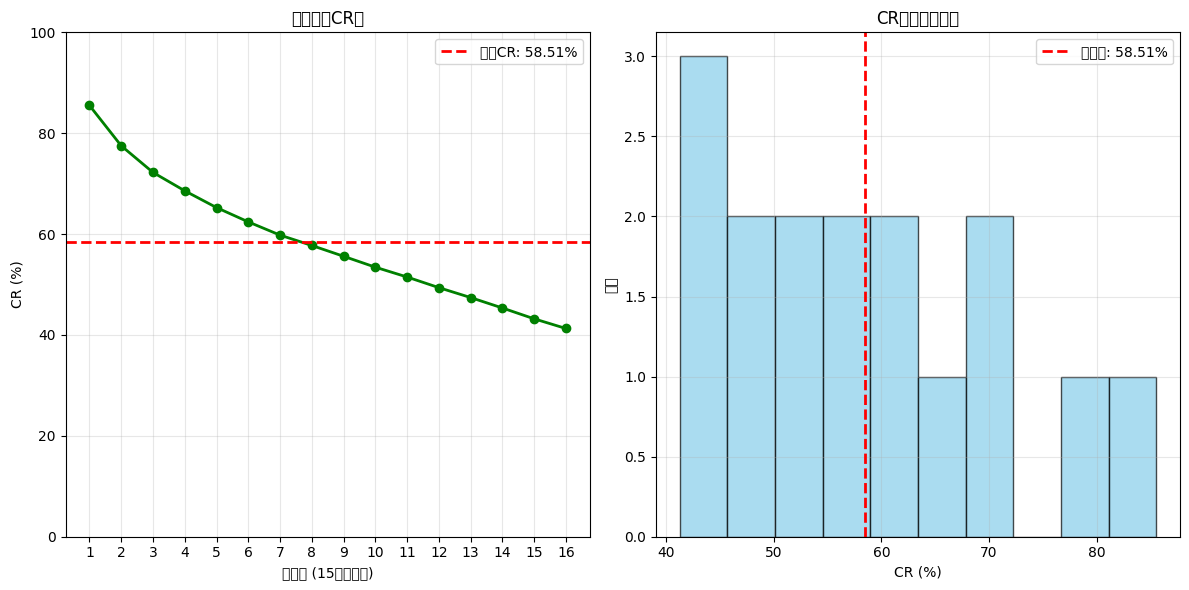


CR统计结果已保存到: /data/jinming/ee_prediction/catboost/results/cr_statistics.json


In [7]:
# 计算平均CR值
print("\n" + "="*60)
print("         CR值统计分析")
print("="*60)

# 1. 计算各个预测点的平均CR
average_cr = np.mean(step_cr)
print(f"各预测点CR值的平均值: {average_cr:.2f}%")

# 2. 显示整体CR值（已计算的）
print(f"整体CR值 (所有预测点合并): {cr_overall:.2f}%")

# 3. 显示每个预测点的CR值
print(f"\n各预测点CR值详情:")
for i, cr_value in enumerate(step_cr):
    print(f"  预测点 t+{i+1} ({(i+1)*15}分钟): {cr_value:.2f}%")

# 4. CR值的统计信息
print(f"\nCR值统计:")
print(f"  最高CR值: {np.max(step_cr):.2f}% (预测点 t+{np.argmax(step_cr)+1})")
print(f"  最低CR值: {np.min(step_cr):.2f}% (预测点 t+{np.argmin(step_cr)+1})")
print(f"  CR值标准差: {np.std(step_cr):.2f}%")
print(f"  CR值中位数: {np.median(step_cr):.2f}%")

# 5. 可视化CR值分布
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, config.pred_length+1), step_cr, 'o-', color='green', linewidth=2, markersize=6)
plt.axhline(y=average_cr, color='red', linestyle='--', linewidth=2, 
            label=f'平均CR: {average_cr:.2f}%')
plt.title('各预测点CR值')
plt.xlabel('预测点 (15分钟间隔)')
plt.ylabel('CR (%)')
plt.grid(alpha=0.3)
plt.xticks(range(1, config.pred_length+1))
plt.legend()
plt.ylim(0, 100)

plt.subplot(1, 2, 2)
plt.hist(step_cr, bins=10, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=average_cr, color='red', linestyle='--', linewidth=2, 
            label=f'平均值: {average_cr:.2f}%')
plt.title('CR值分布直方图')
plt.xlabel('CR (%)')
plt.ylabel('频次')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.results_dir}/cr_analysis.png", dpi=300)
plt.show()

# 6. 保存CR统计结果
cr_stats = {
    'average_cr': float(average_cr),
    'overall_cr': float(cr_overall),
    'max_cr': float(np.max(step_cr)),
    'min_cr': float(np.min(step_cr)),
    'std_cr': float(np.std(step_cr)),
    'median_cr': float(np.median(step_cr)),
    'individual_cr_values': [float(cr) for cr in step_cr]
}

with open(f"{config.results_dir}/cr_statistics.json", "w") as f:
    json.dump(cr_stats, f, indent=2)

print(f"\nCR统计结果已保存到: {config.results_dir}/cr_statistics.json")


         RMSE和MAE统计分析
整体指标 (所有预测点合并):
  整体RMSE: 0.127075
  整体MAE: 0.088137
  整体CR: 56.72%

各预测点指标的平均值:
  平均RMSE: 0.122094
  平均MAE: 0.088137
  平均CR: 58.51%

RMSE统计:
  最高RMSE: 0.169734 (预测点 t+16)
  最低RMSE: 0.043315 (预测点 t+1)
  RMSE标准差: 0.035228
  RMSE中位数: 0.128070

MAE统计:
  最高MAE: 0.126628 (预测点 t+16)
  最低MAE: 0.027643 (预测点 t+1)
  MAE标准差: 0.027800
  MAE中位数: 0.092553

CR统计:
  最高CR: 85.51% (预测点 t+1)
  最低CR: 41.29% (预测点 t+16)
  CR标准差: 12.34%
  CR中位数: 56.67%

各预测点详细指标:
预测点      时间           RMSE         MAE          CR(%)   
------------------------------------------------------------
t+1      15分钟     0.043315     0.027643     85.51   
t+2      30分钟     0.067365     0.044731     77.51   
t+3      45分钟     0.083705     0.057647     72.23   
t+4      60分钟     0.094468     0.065907     68.58   
t+5      75分钟     0.103200     0.072899     65.26   
t+6      90分钟     0.111095     0.078924     62.42   
t+7      105分钟     0.118010     0.084140     59.80   
t+8      120分钟     0.124730     0.089784  

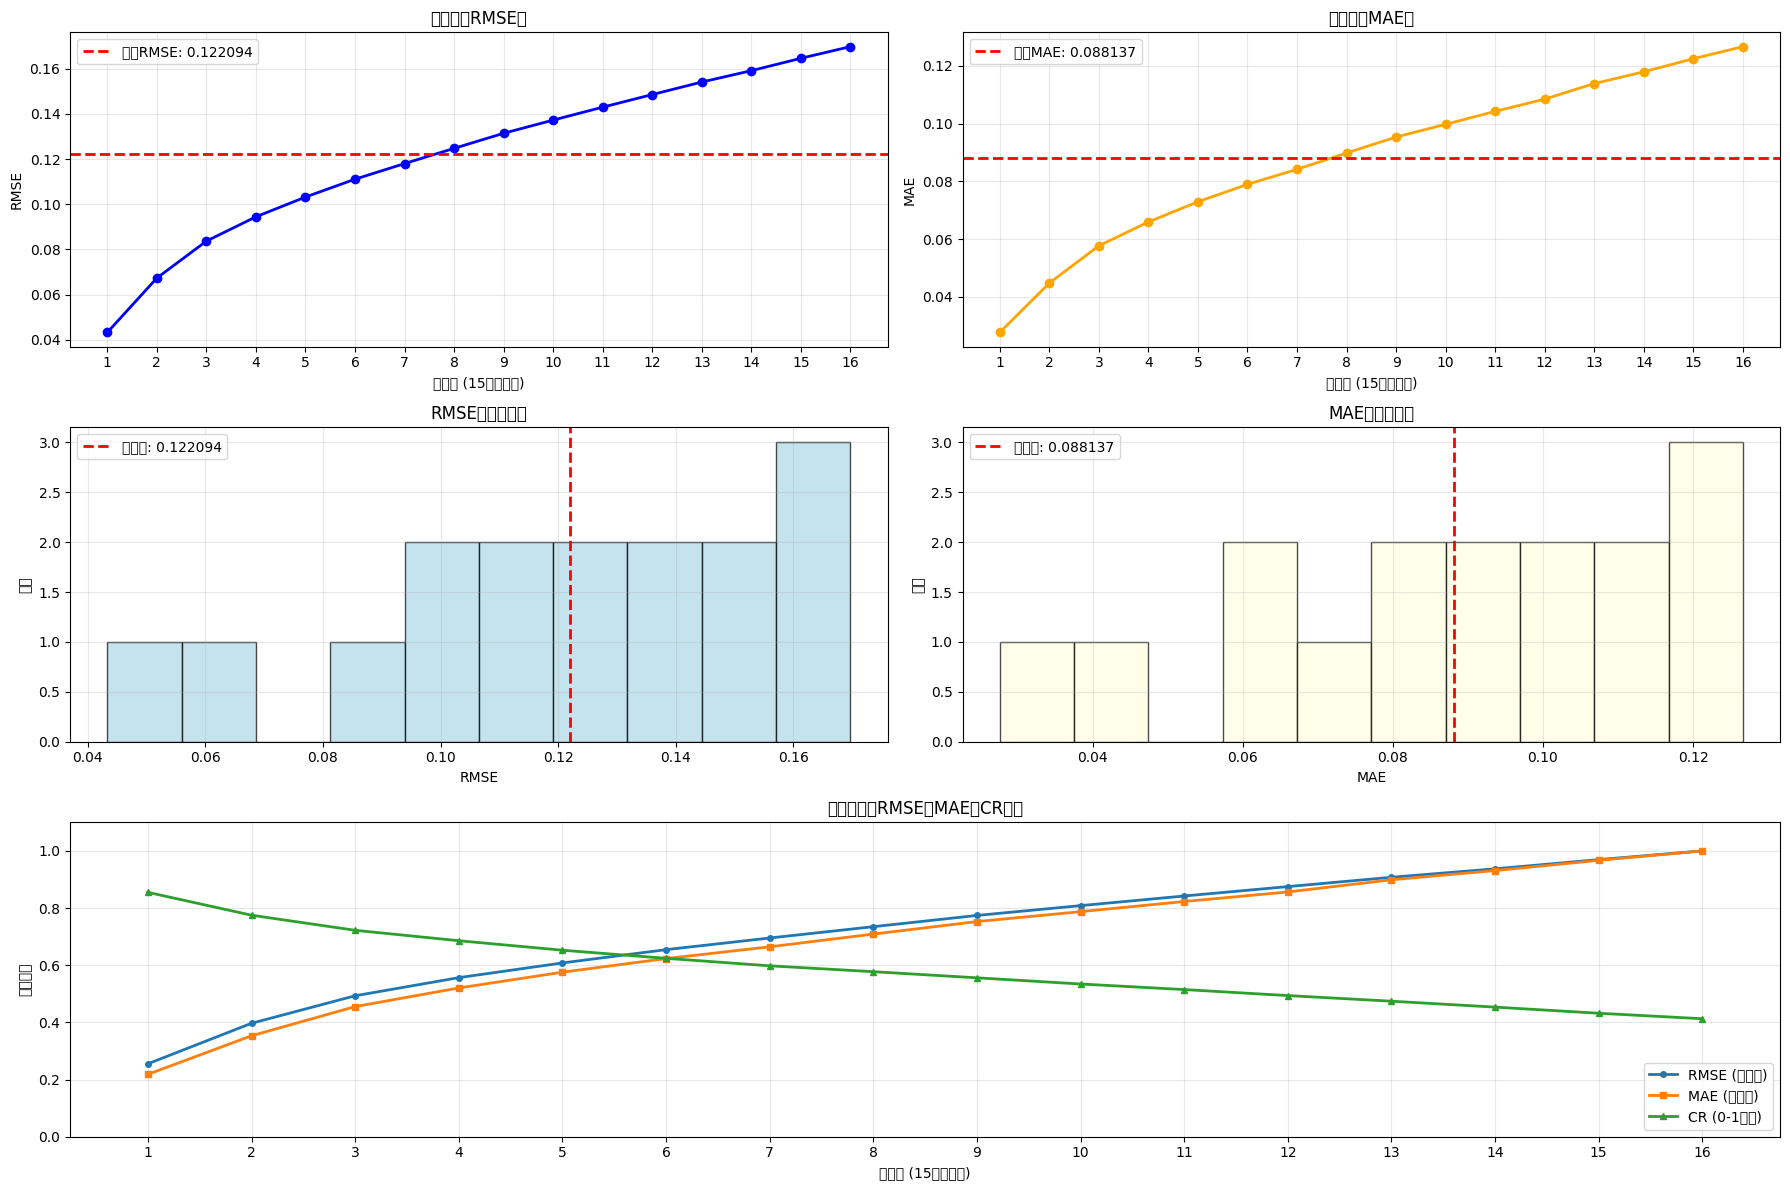


详细指标统计结果已保存到: /data/jinming/ee_prediction/catboost/results/detailed_metrics_statistics.json
可视化结果已保存到: /data/jinming/ee_prediction/catboost/results/rmse_mae_analysis.png


In [11]:
# 计算RMSE和MAE统计分析
print("\n" + "="*60)
print("         RMSE和MAE统计分析")
print("="*60)

# 1. 整体指标
print(f"整体指标 (所有预测点合并):")
print(f"  整体RMSE: {rmse_overall:.6f}")
print(f"  整体MAE: {mae_overall:.6f}")
print(f"  整体CR: {cr_overall:.2f}%")

# 2. 各预测点的平均值
average_rmse = np.mean(step_rmse)
average_mae = np.mean(step_mae)
print(f"\n各预测点指标的平均值:")
print(f"  平均RMSE: {average_rmse:.6f}")
print(f"  平均MAE: {average_mae:.6f}")
print(f"  平均CR: {average_cr:.2f}%")

# 3. 详细统计信息
print(f"\nRMSE统计:")
print(f"  最高RMSE: {np.max(step_rmse):.6f} (预测点 t+{np.argmax(step_rmse)+1})")
print(f"  最低RMSE: {np.min(step_rmse):.6f} (预测点 t+{np.argmin(step_rmse)+1})")
print(f"  RMSE标准差: {np.std(step_rmse):.6f}")
print(f"  RMSE中位数: {np.median(step_rmse):.6f}")

print(f"\nMAE统计:")
print(f"  最高MAE: {np.max(step_mae):.6f} (预测点 t+{np.argmax(step_mae)+1})")
print(f"  最低MAE: {np.min(step_mae):.6f} (预测点 t+{np.argmin(step_mae)+1})")
print(f"  MAE标准差: {np.std(step_mae):.6f}")
print(f"  MAE中位数: {np.median(step_mae):.6f}")

print(f"\nCR统计:")
print(f"  最高CR: {np.max(step_cr):.2f}% (预测点 t+{np.argmax(step_cr)+1})")
print(f"  最低CR: {np.min(step_cr):.2f}% (预测点 t+{np.argmin(step_cr)+1})")
print(f"  CR标准差: {np.std(step_cr):.2f}%")
print(f"  CR中位数: {np.median(step_cr):.2f}%")

# 4. 显示每个预测点的详细指标
print(f"\n各预测点详细指标:")
print(f"{'预测点':<8} {'时间':<12} {'RMSE':<12} {'MAE':<12} {'CR(%)':<8}")
print("-" * 60)
for i in range(config.pred_length):
    print(f"t+{i+1:<6} {(i+1)*15}分钟     {step_rmse[i]:<12.6f} {step_mae[i]:<12.6f} {step_cr[i]:<8.2f}")

# 5. 可视化RMSE、MAE和CR的分布
plt.figure(figsize=(18, 12))

# RMSE随预测时间的变化
plt.subplot(3, 2, 1)
plt.plot(range(1, config.pred_length+1), step_rmse, 'o-', color='blue', linewidth=2, markersize=6)
plt.axhline(y=average_rmse, color='red', linestyle='--', linewidth=2, 
            label=f'平均RMSE: {average_rmse:.6f}')
plt.title('各预测点RMSE值')
plt.xlabel('预测点 (15分钟间隔)')
plt.ylabel('RMSE')
plt.grid(alpha=0.3)
plt.xticks(range(1, config.pred_length+1))
plt.legend()

# MAE随预测时间的变化
plt.subplot(3, 2, 2)
plt.plot(range(1, config.pred_length+1), step_mae, 'o-', color='orange', linewidth=2, markersize=6)
plt.axhline(y=average_mae, color='red', linestyle='--', linewidth=2, 
            label=f'平均MAE: {average_mae:.6f}')
plt.title('各预测点MAE值')
plt.xlabel('预测点 (15分钟间隔)')
plt.ylabel('MAE')
plt.grid(alpha=0.3)
plt.xticks(range(1, config.pred_length+1))
plt.legend()

# RMSE分布直方图
plt.subplot(3, 2, 3)
plt.hist(step_rmse, bins=10, color='lightblue', alpha=0.7, edgecolor='black')
plt.axvline(x=average_rmse, color='red', linestyle='--', linewidth=2, 
            label=f'平均值: {average_rmse:.6f}')
plt.title('RMSE分布直方图')
plt.xlabel('RMSE')
plt.ylabel('频次')
plt.legend()
plt.grid(alpha=0.3)

# MAE分布直方图
plt.subplot(3, 2, 4)
plt.hist(step_mae, bins=10, color='lightyellow', alpha=0.7, edgecolor='black')
plt.axvline(x=average_mae, color='red', linestyle='--', linewidth=2, 
            label=f'平均值: {average_mae:.6f}')
plt.title('MAE分布直方图')
plt.xlabel('MAE')
plt.ylabel('频次')
plt.legend()
plt.grid(alpha=0.3)

# 三个指标的综合比较
plt.subplot(3, 1, 3)
# 标准化指标以便在同一图上显示
rmse_normalized = np.array(step_rmse) / np.max(step_rmse)
mae_normalized = np.array(step_mae) / np.max(step_mae)
cr_normalized = np.array(step_cr) / 100  # CR已经是百分比

x_points = range(1, config.pred_length+1)
plt.plot(x_points, rmse_normalized, 'o-', label='RMSE (标准化)', linewidth=2, markersize=4)
plt.plot(x_points, mae_normalized, 's-', label='MAE (标准化)', linewidth=2, markersize=4)
plt.plot(x_points, cr_normalized, '^-', label='CR (0-1缩放)', linewidth=2, markersize=4)

plt.title('标准化后的RMSE、MAE和CR对比')
plt.xlabel('预测点 (15分钟间隔)')
plt.ylabel('标准化值')
plt.grid(alpha=0.3)
plt.xticks(range(1, config.pred_length+1))
plt.legend()
plt.ylim(0, 1.1)

plt.tight_layout()
plt.savefig(f"{config.results_dir}/rmse_mae_analysis.png", dpi=300)
plt.show()

# 6. 保存详细统计结果
detailed_stats = {
    'overall_metrics': {
        'rmse': float(rmse_overall),
        'mae': float(mae_overall),
        'cr': float(cr_overall)
    },
    'average_metrics': {
        'rmse': float(average_rmse),
        'mae': float(average_mae),
        'cr': float(average_cr)
    },
    'rmse_stats': {
        'max': float(np.max(step_rmse)),
        'min': float(np.min(step_rmse)),
        'std': float(np.std(step_rmse)),
        'median': float(np.median(step_rmse)),
        'max_at_point': int(np.argmax(step_rmse) + 1),
        'min_at_point': int(np.argmin(step_rmse) + 1)
    },
    'mae_stats': {
        'max': float(np.max(step_mae)),
        'min': float(np.min(step_mae)),
        'std': float(np.std(step_mae)),
        'median': float(np.median(step_mae)),
        'max_at_point': int(np.argmax(step_mae) + 1),
        'min_at_point': int(np.argmin(step_mae) + 1)
    },
    'cr_stats': {
        'max': float(np.max(step_cr)),
        'min': float(np.min(step_cr)),
        'std': float(np.std(step_cr)),
        'median': float(np.median(step_cr)),
        'max_at_point': int(np.argmax(step_cr) + 1),
        'min_at_point': int(np.argmin(step_cr) + 1)
    },
    'individual_values': {
        'rmse': [float(x) for x in step_rmse],
        'mae': [float(x) for x in step_mae],
        'cr': [float(x) for x in step_cr]
    }
}

with open(f"{config.results_dir}/detailed_metrics_statistics.json", "w") as f:
    json.dump(detailed_stats, f, indent=2)

print(f"\n详细指标统计结果已保存到: {config.results_dir}/detailed_metrics_statistics.json")
print(f"可视化结果已保存到: {config.results_dir}/rmse_mae_analysis.png")

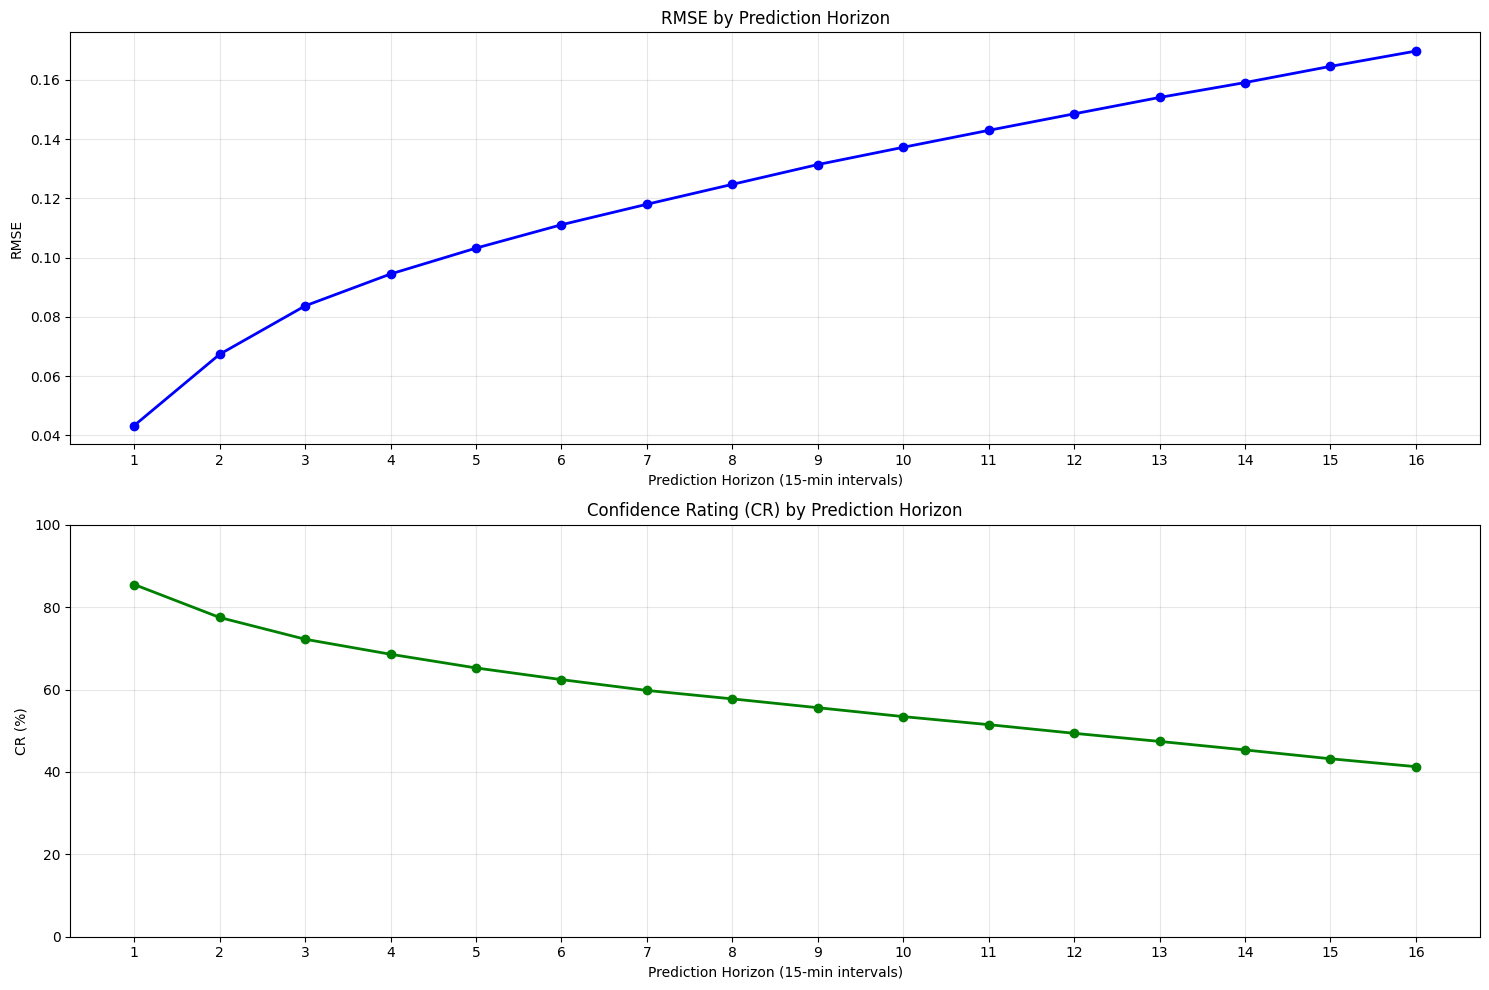

In [9]:
# 比较不同预测时间点的模型性能

# 1. 每个预测点的RMSE和CR
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(range(1, config.pred_length+1), step_rmse, 'o-', color='blue', linewidth=2)
plt.title('RMSE by Prediction Horizon')
plt.xlabel('Prediction Horizon (15-min intervals)')
plt.ylabel('RMSE')
plt.grid(alpha=0.3)
plt.xticks(range(1, config.pred_length+1))



plt.subplot(2, 1, 2)
plt.plot(range(1, config.pred_length+1), step_cr, 'o-', color='green', linewidth=2)
plt.title('Confidence Rating (CR) by Prediction Horizon')
plt.xlabel('Prediction Horizon (15-min intervals)')
plt.ylabel('CR (%)')
plt.grid(alpha=0.3)
plt.xticks(range(1, config.pred_length+1))
plt.ylim(0, 100)



plt.tight_layout()
plt.savefig(f"{config.results_dir}/performance_by_horizon.png", dpi=300)
plt.show()



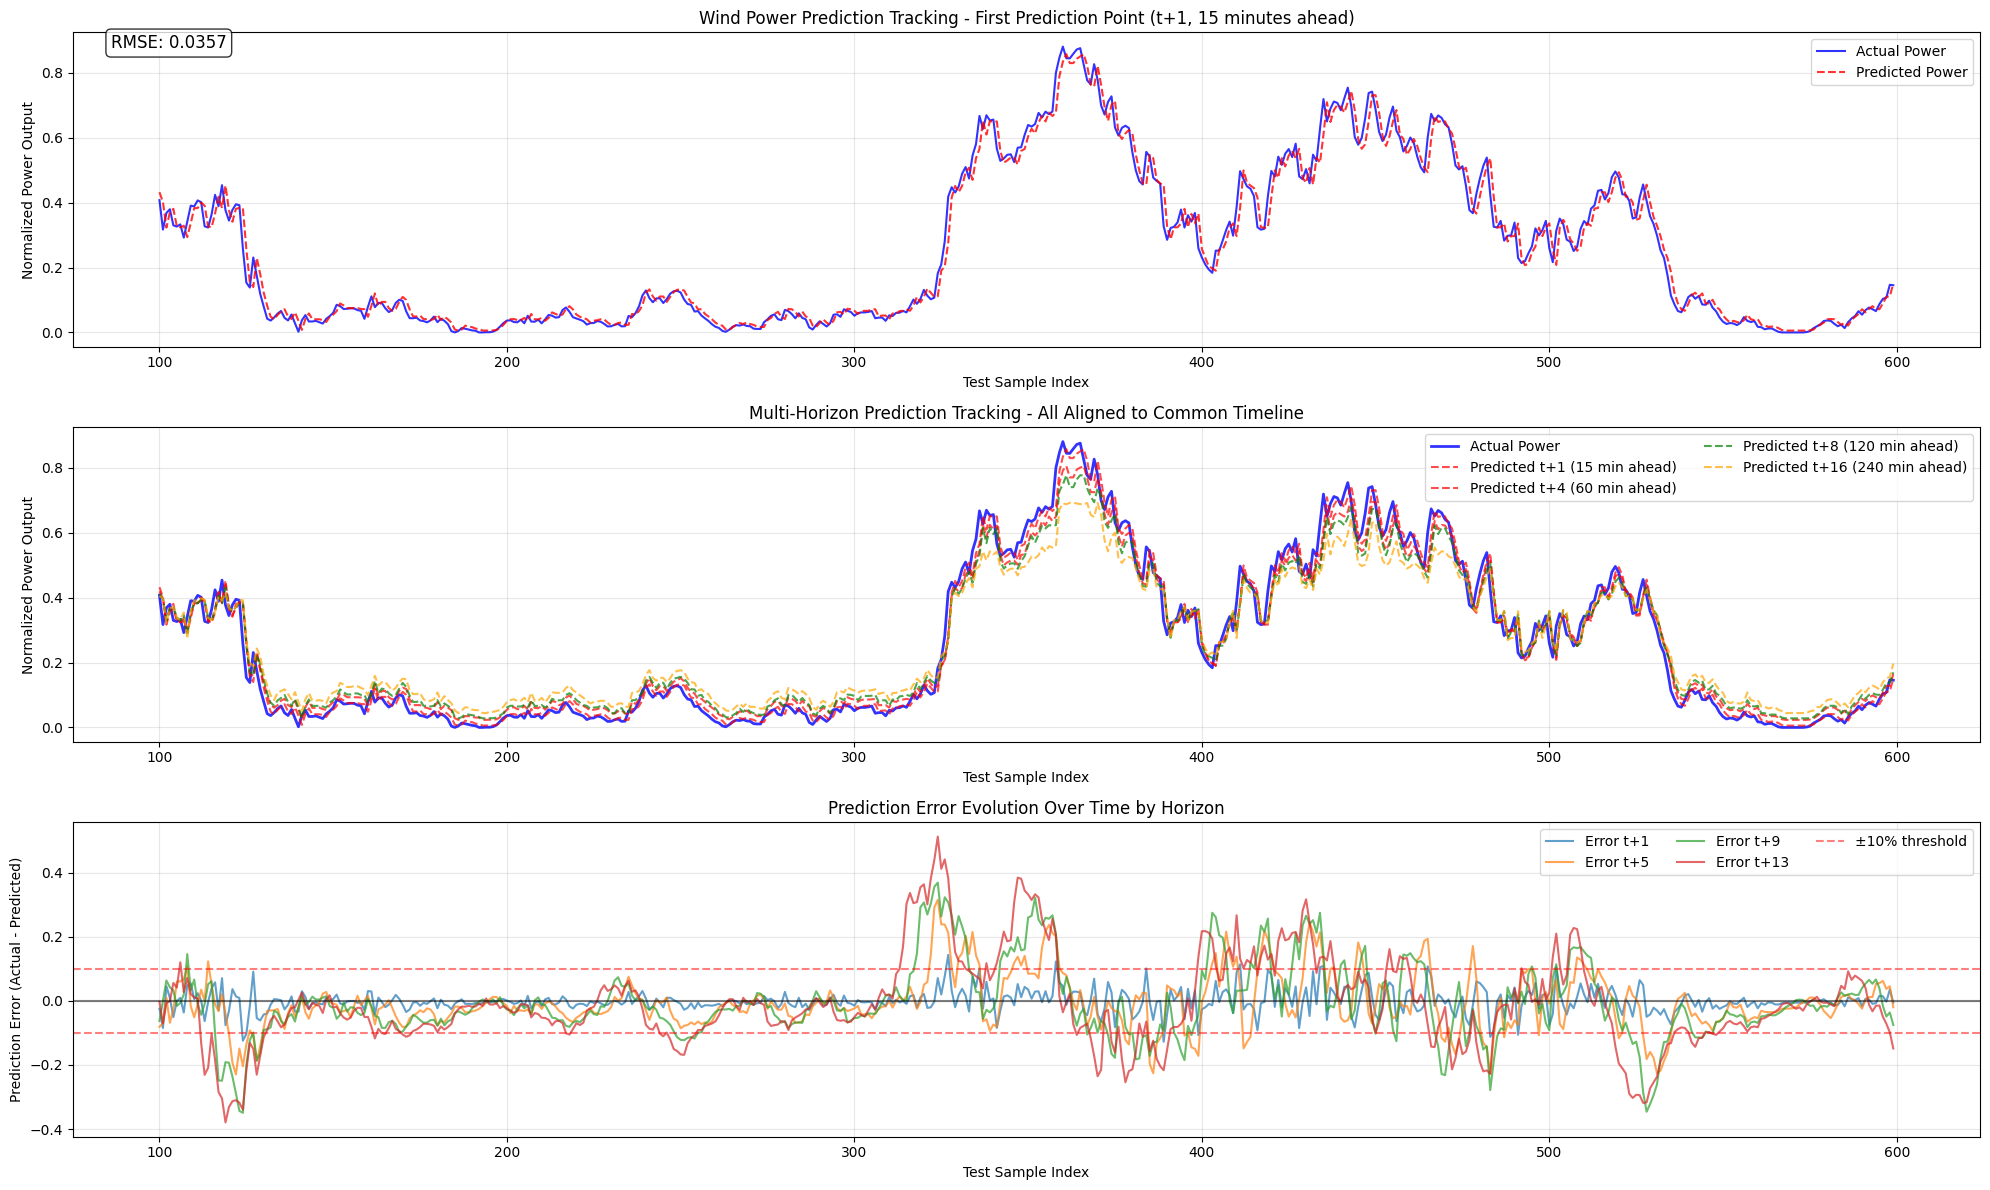

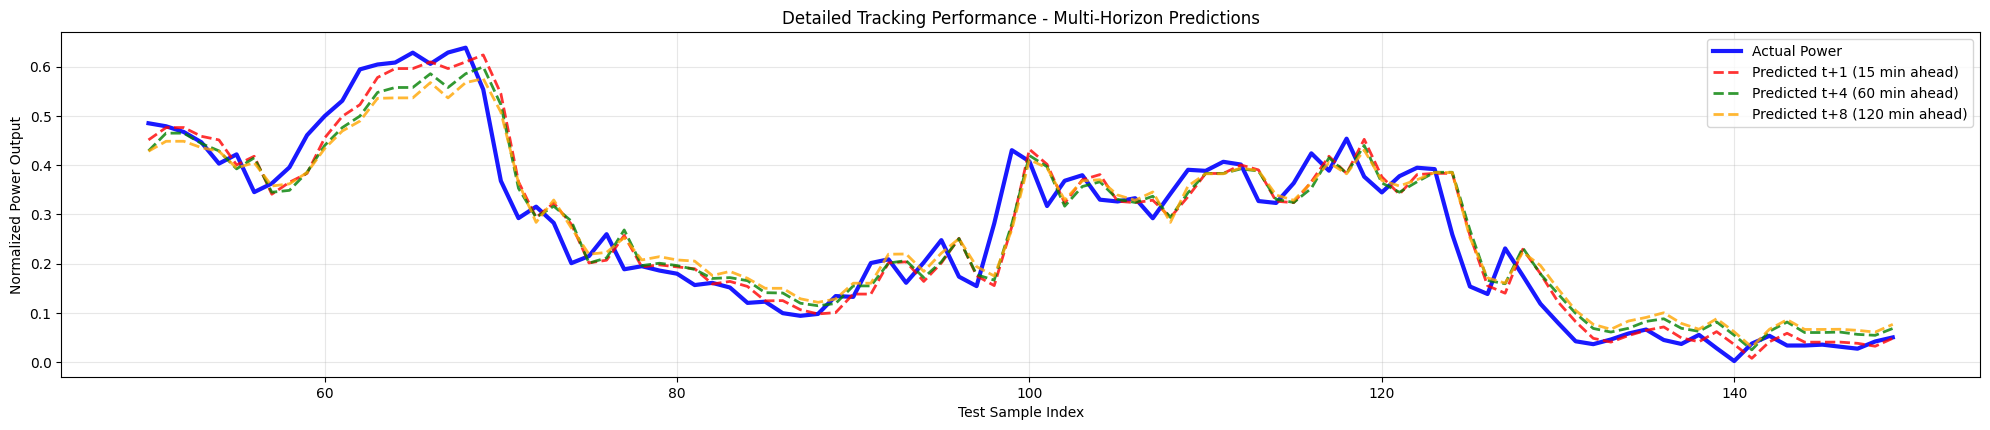

Tracking visualizations saved to /data/jinming/ee_prediction/catboost/results
Shown segment: samples 100 to 600
Overall tracking RMSE (t+1): 0.0357
Note: All predictions are aligned to the same timeline for comparison


In [10]:
# Create comprehensive time series visualization for test set tracking
plt.figure(figsize=(20, 12))

# Select a continuous segment from test set to show tracking performance
start_idx = 100  # Start from beginning of test set
segment_length = min(500, len(y_test))  # Show first 500 samples or all if less

# Create time axis for the segment
time_axis = np.arange(start_idx, start_idx + segment_length)

# Plot 1: Overall tracking performance for first prediction point
plt.subplot(3, 1, 1)

# For visualization, we'll show the tracking for the first prediction point (t+1)
actual_series = y_test[start_idx:start_idx + segment_length, 0]  # First prediction point
predicted_series = test_predictions[start_idx:start_idx + segment_length, 0]

plt.plot(time_axis, actual_series, 'b-', linewidth=1.5, label='Actual Power', alpha=0.8)
plt.plot(time_axis, predicted_series, 'r--', linewidth=1.5, label='Predicted Power', alpha=0.8)
plt.title('Wind Power Prediction Tracking - First Prediction Point (t+1, 15 minutes ahead)')
plt.xlabel('Test Sample Index')
plt.ylabel('Normalized Power Output')
plt.legend()
plt.grid(alpha=0.3)

# Add RMSE annotation
rmse_segment = np.sqrt(mean_squared_error(actual_series, predicted_series))
plt.text(0.02, 0.95, f'RMSE: {rmse_segment:.4f}', transform=plt.gca().transAxes, 
         fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Multi-horizon tracking with time alignment
plt.subplot(3, 1, 2)
colors = ['blue', 'red', 'green', 'orange']
horizons_to_show = [0, 3, 7, 15]  # Show 1st, 4th, 8th, and 16th prediction points

# Create a common actual power reference line
# Use the actual values that correspond to what each horizon is trying to predict
actual_reference = y_test[start_idx:start_idx + segment_length, 0]
plt.plot(time_axis, actual_reference, color='blue', linestyle='-', linewidth=2, 
         alpha=0.8, label='Actual Power')

# Plot predictions for different horizons
for i, horizon in enumerate(horizons_to_show):
    if horizon == 0:
        # For the first horizon, plot directly
        predicted_h = test_predictions[start_idx:start_idx + segment_length, horizon]
        plt.plot(time_axis, predicted_h, color=colors[i+1], linestyle='--', linewidth=1.5, 
                alpha=0.7, label=f'Predicted t+{horizon+1} ({(horizon+1)*15} min ahead)')
    else:
        # For other horizons, we need to align properly
        # The prediction at sample i for horizon h should align with actual at sample i
        predicted_h = test_predictions[start_idx:start_idx + segment_length, horizon]
        plt.plot(time_axis, predicted_h, color=colors[i], linestyle='--', linewidth=1.5, 
                alpha=0.7, label=f'Predicted t+{horizon+1} ({(horizon+1)*15} min ahead)')

plt.title('Multi-Horizon Prediction Tracking - All Aligned to Common Timeline')
plt.xlabel('Test Sample Index')
plt.ylabel('Normalized Power Output')
plt.legend(ncol=2, loc='upper right')
plt.grid(alpha=0.3)

# Plot 3: Error evolution over time for different horizons
plt.subplot(3, 1, 3)
# Show prediction errors for different horizons
for i, horizon in enumerate(range(0, config.pred_length, 4)):  # Show every 4th horizon
    if horizon < config.pred_length:
        # Calculate errors for this horizon
        actual_h = y_test[start_idx:start_idx + segment_length, horizon]
        predicted_h = test_predictions[start_idx:start_idx + segment_length, horizon]
        errors_h = actual_h - predicted_h
        
        plt.plot(time_axis, errors_h, linewidth=1.5, alpha=0.7, 
                label=f'Error t+{horizon+1}')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='±10% threshold')
plt.axhline(y=-0.1, color='red', linestyle='--', alpha=0.5)
plt.title('Prediction Error Evolution Over Time by Horizon')
plt.xlabel('Test Sample Index')
plt.ylabel('Prediction Error (Actual - Predicted)')
plt.legend(ncol=3, loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.results_dir}/test_tracking_performance.png", dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed view: Focus on a shorter segment for better detail
plt.figure(figsize=(20, 8))

# Select a shorter segment for detailed view
detail_start = 50
detail_length = 100
detail_time = np.arange(detail_start, detail_start + detail_length)

plt.subplot(2, 1, 1)
# Show actual power for the first horizon as reference
actual_detail = y_test[detail_start:detail_start + detail_length, 0]
plt.plot(detail_time, actual_detail, 'b-', linewidth=3, alpha=0.9, label='Actual Power')

# Show predicted lines for different horizons
horizons_detail = [0, 3, 7]  # 1st, 4th, 8th prediction points
colors_detail = ['red', 'green', 'orange']

for i, horizon in enumerate(horizons_detail):
    predicted_detail = test_predictions[detail_start:detail_start + detail_length, horizon]
    plt.plot(detail_time, predicted_detail, color=colors_detail[i], linestyle='--', 
            linewidth=2, alpha=0.8,
            label=f'Predicted t+{horizon+1} ({(horizon+1)*15} min ahead)')

plt.title('Detailed Tracking Performance - Multi-Horizon Predictions')
plt.xlabel('Test Sample Index')
plt.ylabel('Normalized Power Output')
plt.legend()
plt.grid(alpha=0.3)



plt.tight_layout()
plt.savefig(f"{config.results_dir}/detailed_tracking_performance.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Tracking visualizations saved to {config.results_dir}")
print(f"Shown segment: samples {start_idx} to {start_idx + segment_length}")
print(f"Overall tracking RMSE (t+1): {rmse_segment:.4f}")
print("Note: All predictions are aligned to the same timeline for comparison")